
## Detailed Methodology, Interpretations, and Findings

This section outlines the step-by-step process followed in this project, detailing the methods used, the reasoning behind them, key interpretations from each stage, and the final results obtained from the predictive models.

### 1. Data Loading and Initial Preprocessing (`COLAB CELL 2`, `COLAB CELL 3`, `COLAB CELL 4`)

**Goal**: To load raw forest cover data and state boundaries, convert disparate formats into a unified structure, and perform initial cleaning.

*   **Data Acquisition**: Two Excel files (`Forest Coverage (1987-2013).xlsx` and `Forest.xlsx`) containing historical forest area statistics for Indian states/UTs were loaded into pandas DataFrames (`df1`, `df2`). Additionally, a shapefile (`Indian_states.shp`) providing geographical boundaries for Indian states was loaded into a GeoDataFrame (`india_gdf`).
*   **Wide-to-Long Transformation**: The `df1` (forest coverage from 1987-2013) was initially in a wide format, with years as columns. A custom `wide_to_long` function was applied to transform it into a long format (`long1`), where each row represents a `state`, `year`, and its corresponding `forest_area`. This structure is crucial for time series analysis.
*   **Data Cleaning (`long1` -> `df`)**:
    *   **Forest Area Column**: The `forest_area` column, initially of object type, contained commas and hyphens ('-'). Commas were removed, and hyphens were replaced with `NaN` (Not a Number) to enable conversion to a numeric (`float`) data type.
    *   **State Name Standardization**: `State/UTs` column values were cleaned by stripping whitespace and converting to uppercase to ensure consistency for merging with the geographical data. `ARUNACHAL PRADESH` was corrected to `ARUNANCHAL PRADESH` to match the shapefile.
    *   **Data Type Conversion**: The `year` column was explicitly converted to `int`, and `forest_area` to `float`.
    *   **Missing Value Imputation**: Rows with missing `forest_area` values were handled by sorting data by `state` and `year`, and then using linear interpolation (`interpolate()`) within each state group. This assumes a smooth transition of forest cover over time. After interpolation, any remaining `NaN`s (from initial years or states with only `NaN`s) were dropped.
    *   **Removal of Aggregate Rows**: Rows representing aggregate data like 'PER CENT' and 'GRAND TOTAL' were removed to focus on individual state analysis.

**Interpretation & Findings**: Initial data exploration (e.g., `df1.head()`, `df1.info()`, `df1.describe()`) revealed the need for significant cleaning and restructuring. The wide-to-long conversion successfully prepared the data for time series analysis. State name standardization was critical for accurate merging with geographical data, and interpolation helped retain valuable time-series information for states with intermittent reporting.

### 2. Feature Engineering (`COLAB CELL 4`)

**Goal**: To create new features that capture temporal dependencies and enhance the predictive power of models.

*   **Lag Features**: `forest_area_lag1` was created by shifting `forest_area` by one period (year). This feature represents the forest area in the previous measurement period, crucial for time series prediction.
*   **Growth Rate**: `forest_growth_rate` was calculated as the percentage change in `forest_area` from the previous period. This provides insight into the rate of change in forest cover.
*   **Rolling Mean**: `forest_area_roll3` was computed as the 3-period rolling mean of `forest_area`. This feature helps smooth out short-term fluctuations and capture longer-term trends.
*   **Handling `NaN`s Post-Feature Engineering**: Rows that still contained `NaN` values (primarily the first year for each state due to lag features) were dropped, ensuring a clean dataset for modeling.

**Interpretation & Findings**: These features are designed to provide the models with information about past states and trends of forest cover. `forest_area_lag1` is often the most significant predictor in time series, while growth rate and rolling mean offer additional dynamic context.

### 3. Merging with Geographical Data (`COLAB CELL 5` & `COLAB CELL 6`)

**Goal**: To combine the processed forest data with spatial information for visualization and to calculate forest cover percentage.

*   **State Name Alignment**: Further standardization of state names was performed (e.g., 'A & N ISLANDS' to 'ANDAMAN & NICOBAR ISLAND', 'ORISSA' to 'ODISHA') to ensure a perfect match with the `st_nm` column in `india_gdf`.
*   **Geospatial Merge**: The processed forest data (`df`) was merged with `india_gdf` using the standardized state names. This added the `geometry` column (representing state polygons) to our main DataFrame (`merged`).
*   **Area Calculation**: To calculate accurate forest cover percentages, the geographical area of each state was calculated in hectares (`area_ha`) using an equal-area projection (EPSG:6933) and then merged back into the `merged` DataFrame.
*   **Forest Percentage Calculation**: `forest_pct` was calculated by dividing `forest_area` by `area_ha` and multiplying by 100, providing a standardized measure of forest cover.

**Interpretation & Findings**: The merge created a comprehensive `GeoDataFrame` (`merged`) containing both temporal and spatial attributes of forest cover. The `forest_pct` feature is a normalized and interpretable measure of forest cover, essential for comparative analysis and visualization.

### 4. Exploratory Data Analysis (EDA) & Visualization (`COLAB CELL 7` & `COLAB CELL 8`)

**Goal**: To understand data distributions, correlations, and temporal patterns.

*   **Correlation Heatmap**: A heatmap of feature correlations (`forest_area`, `forest_area_lag1`, `forest_growth_rate`, `forest_area_roll3`, `forest_pct`) was generated. This revealed strong positive correlations between `forest_area`, `forest_area_lag1`, and `forest_area_roll3`, as expected for time series data.
*   **Forest Area Trends**: Line plots were generated to visualize the `forest_area` trend over time (1987-2013) for groups of states. This helped identify states with increasing, decreasing, or stable forest cover.
*   **Growth Rate Distribution**: A histogram of `forest_growth_rate` was plotted to understand its distribution, showing the prevalence of positive, negative, and near-zero growth rates across states.

**Interpretation & Findings**: The EDA confirmed expected relationships between lagged features and the target variable. Visualizing trends for individual states highlighted the diverse patterns of forest change across India, underscoring the need for models that can capture state-specific dynamics.

### 5. Predictive Modeling

#### 5.1 ARIMA (AutoRegressive Integrated Moving Average) Model (`COLAB CELL 9` & `COLAB CELL 10`)

**Goal**: To forecast future forest area for each state using a traditional time series model.

*   **Model Application**: For each state, a time series of `forest_area` (indexed by `year`) was extracted. An `ARIMA(1,1,1)` model was fitted to each state's time series using `statsmodels.tsa.arima.model.ARIMA`. The `(1,1,1)` order indicates one AR term, one differencing, and one MA term, chosen as a common starting point for non-stationary time series.
*   **Forecasting**: Each fitted ARIMA model was used to forecast `forest_area` for 10 future periods (biennial years from 2015 to 2033).
*   **Visualization**: Plots were generated comparing the historical `forest_area` with the ARIMA forecasts for selected states (e.g., Andhra Pradesh, Assam, Odisha).

**Interpretation & Findings**: ARIMA models provide independent forecasts for each state, capturing their unique historical patterns. The plots visually demonstrate how well the model extrapolates the historical trend. Some states show stable forecasts, while others show continuation of historical increase or decrease. The `ARIMA` model is purely based on the time series of forest area and does not incorporate other features.

#### 5.2 Random Forest Regressor (`COLAB CELL 11`)

**Goal**: To predict forest area using a robust machine learning model that leverages engineered features.

*   **Data Preparation**: The `merged` DataFrame was used, and rows with `NaN` values in the feature set (`forest_area_lag1`, `forest_area_roll3`, `forest_growth_rate`, `forest_pct`) were dropped, as were `inf` values. The features (`X`) were defined as `forest_area_lag1`, `forest_area_roll3`, `forest_growth_rate`, and `forest_pct`, with `forest_area` as the target variable (`y`).
*   **Train-Test Split**: The data was split into training (80%) and testing (20%) sets to evaluate model performance on unseen data, with `random_state=42` for reproducibility.
*   **Model Training**: A `RandomForestRegressor` with `n_estimators=200` was initialized and trained on the training data.
*   **Model Evaluation**: Predictions were made on the test set, and performance was evaluated using:
    *   **R² Score**: Measures the proportion of variance in the dependent variable that can be predicted from the independent variables. A score closer to 1 indicates a better fit.
    *   **Mean Absolute Error (MAE)**: Measures the average magnitude of the errors in a set of predictions, without considering their direction. It's the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

**Interpretation & Findings**: The Random Forest model achieved an **R² Score of 0.9984** and an **MAE of 422.75**. This indicates an exceptionally strong fit and highly accurate predictions. The model is very effective at capturing the relationships between the engineered features and forest area, suggesting that past forest area, its trend, and growth rate are powerful predictors.

#### 5.3 Linear Mixed Effects Model (LMM) (`COLAB CELL 12`)

**Goal**: To analyze the overall trend of forest area change across all states while accounting for state-specific variability.

*   **Model Specification**: A Linear Mixed Effects Model was fitted using `statsmodels.formula.api.mixedlm`. The formula `forest_area ~ year` specified `forest_area` as the dependent variable and `year` as a fixed effect. The `groups=merged['state']` parameter indicated that `state` should be treated as a grouping variable for random effects (allowing for state-specific intercepts).
*   **Fixed Effects Interpretation**: The coefficient for `year` represents the estimated average annual change in forest area across all states.
*   **Random Effects Interpretation**: The `Group Var` (variance component for the `state` group) quantifies the extent of variation in intercepts among different states. A significant variance indicates that states have different baseline forest areas or different average trends.

**Interpretation & Findings**: The LMM results provided the following insights:
    *   **Fixed Effect for `year`**: The coefficient was **-73.7690**, with a p-value of **0.0757**. This suggests an estimated average annual *decrease* of approximately 73.77 sq km in forest area across all states. The p-value, being slightly above 0.05, indicates marginal statistical significance at a 5% level, but it still points towards a general decreasing trend.
    *   **Random Effect (Group Var)**: The variance component for the 'state' group was **474030203.5480**. This highly significant variance indicates that there are substantial state-specific deviations from the overall average trend. In simpler terms, different states have very different starting forest areas and/or unique trajectories of forest cover change that are not fully explained by the overall linear trend with respect to year. This confirms that treating each state as an independent entity (as with ARIMA) or including state-level features is important.

### 6. Final Prediction Results & Geospatial Visualization (`COLAB CELL 12` & `COLAB CELL 13`)

**Goal**: To visualize and compare the spatial predictions from both Random Forest and ARIMA models.

*   **Random Forest Predictions for Mapping**: The trained Random Forest model was used to predict `forest_area` for each state using the latest available historical data (2013 in this case) as input. These predictions were then merged with the `india_gdf` to calculate and visualize `predicted_forest_pct` for the year *following* the last historical input (e.g., implying 2015 using 2013 features).
*   **ARIMA Predictions for Mapping**: For a specific forecast year (e.g., 2015), the ARIMA forecasts for each state were extracted. These were also merged with `india_gdf` to calculate and visualize `predicted_forest_pct` for the chosen ARIMA forecast year.
*   **Comparison Maps**: Side-by-side choropleth maps were generated to visually compare the `predicted_forest_pct` from the Random Forest (based on 2013 data) and the ARIMA model (for 2015).
*   **Difference Map**: A map illustrating the difference in predicted forest cover percentage between the ARIMA forecast and the Random Forest prediction was created. This map highlights states where the two models diverge in their future outlook, indicating areas where model uncertainty or differing assumptions have a larger impact.

**Interpretation & Findings**: The geospatial visualizations provide a powerful way to understand the spatial distribution of predicted forest cover and to identify regional patterns. The comparison and difference maps highlight that while both models aim to predict forest area, their underlying mechanisms (time series extrapolation vs. feature-based regression) can lead to notable differences in predictions for specific states. For example, states where the growth rate was highly variable might see different predictions from the Random Forest (which considers the recent growth rate feature) compared to ARIMA (which smooths out overall trends).

**Overall Prediction Results Summary**:

*   **Random Forest**: Achieved very high accuracy (R² ~ 0.998) in predicting forest area, demonstrating its ability to leverage historical features effectively. Its predictions offer a strong estimate for the immediate future based on learned relationships from the past data.
*   **ARIMA**: Provided state-specific forecasts that extrapolate individual state trends. While less accurate on specific points than the Random Forest (which benefited from multiple engineered features), it offers a straightforward time series projection.
*   **LMM**: Revealed a marginal overall decreasing trend in forest area across India, but critically, identified significant state-level heterogeneity, emphasizing that a uniform trend does not apply to all regions. This supports the use of state-specific models or models that account for state-level differences.

In [ ]:
# COLAB CELL 0: Install dependencies
!pip install rioxarray rasterio rasterstats folium matplotlib scikit-learn \
xgboost lightgbm statsmodels pmdarima optuna shap
# prophet is optional:
!pip install prophet


In [ ]:
# COLAB CELL 1: Imports & helpers
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rioxarray as rxr
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# helper: safe read excel (handles multiple sheets)
def read_excel_any(path):
    try:
        return pd.read_excel(path)
    except Exception:
        return pd.concat(pd.read_excel(path, sheet_name=None), ignore_index=True)

# helper: print basic info
def summarise_df(df, name='df'):
    print(f"--- {name} ---")
    print(df.head())
    print(df.info())
    print(df.describe(include='all'))


In [ ]:
# COLAB CELL 2: Load datasets
forest_path1 = '/content/Forest Data/Forest Coverage (1987-2013).xlsx'
forest_path2 = '/content/Forest Data/Forest.xlsx'
# for country boundary (India full)
india_shapefile = '/content/India GIS data/India Boundary/India_boundary.shp'

# for states boundary (use this if you want per-state analysis)
india_states_shapefile = '/content/India GIS data/India States/Indian_states.shp'


df1 = read_excel_any(forest_path1)
df2 = read_excel_any(forest_path2)

summarise_df(df1, 'forest_1987_2013')
summarise_df(df2, 'forest_other')

india_gdf = gpd.read_file(india_states_shapefile)
print("States shapefile loaded, CRS:", india_gdf.crs)
india_gdf = india_gdf.to_crs(epsg=4326)
print("Reprojected to EPSG:4326")
print("Shapefile columns:", india_gdf.columns.tolist())
india_gdf.head()


--- forest_1987_2013 ---
           State/UTs    1987    1989    1991    1993    1995    1997    1999  \
0     Andhra Pradesh  49,573  47,290  47,290  47,256  47,112  43,290  44,229   
1  Arunachal Pradesh  64,132  69,002  68,757  68,661  68,621  68,602  68,847   
2              Assam  25,160  24,832  24,751  24,508  24,061  23,824  23,688   
3              Bihar  28,482  26,668  26,668  26,587  26,561   4,832   4,830   
4       Chhattisgarh       -       -       -       -       -  56,435  56,693   

     2001    2003    2005    2007    2011    2013  
0  44,637  44,419  44,372  45,102  46,389  46,116  
1  68,045  68,019  67,777  67,353  67,410  67,321  
2  27,714  27,826  27,645  27,692  27,673  27,671  
3   5,720   5,558   5,579   6,804   6,845   7,291  
4  56,448  55,998  55,863  55,870  55,674  55,621  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 

,st_nm,geometry
0,Andaman & Nicobar Island,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,Arunanchal Pradesh,"POLYGON ((96.16261 29.38078, 96.1686 29.37432,..."
2,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.7429 26...."
3,Bihar,"MULTIPOLYGON (((84.5072 24.26323, 84.50355 24...."
4,Chandigarh,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [ ]:
# COLAB CELL 3: Convert wide-to-long
def wide_to_long(df, id_vars=None, year_prefix=None):
    if id_vars is None:
        id_vars = [c for c in df.columns if not c.strip().isdigit()]
    year_cols = [c for c in df.columns if c.strip().isdigit() or
                 (year_prefix and c.startswith(year_prefix))]
    if not year_cols:
        year_cols = [c for c in df.columns if any(ch.isdigit() for ch in c)]
    if not year_cols:
        print('No clear year columns detected; returning original df')
        return df
    long = df.melt(id_vars=id_vars, value_vars=year_cols,
                   var_name='year', value_name='forest_area')
    long['year'] = long['year'].astype(str).str.extract('([0-9]{4})').astype(float)
    return long

long1 = wide_to_long(df1)
long2 = wide_to_long(df2)

summarise_df(long1, 'long1')


No clear year columns detected; returning original df
--- long1 ---
           State/UTs    year forest_area
0     Andhra Pradesh  1987.0      49,573
1  Arunachal Pradesh  1987.0      64,132
2              Assam  1987.0      25,160
3              Bihar  1987.0      28,482
4       Chhattisgarh  1987.0           -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   State/UTs    481 non-null    object 
 1   year         481 non-null    float64
 2   forest_area  481 non-null    object 
dtypes: float64(1), object(2)
memory usage: 11.4+ KB
None
             State/UTs         year forest_area
count              481   481.000000         481
unique              37          NaN         398
top     Andhra Pradesh          NaN           0
freq                13          NaN          21
mean               NaN  1999.307692         NaN
std                NaN    

In [ ]:
# Clean forest_area column: remove commas, replace "-" with NaN, convert to numeric
long1['forest_area'] = (
    long1['forest_area']
    .replace("-", np.nan)            # replace dash with NaN
    .str.replace(",", "", regex=True) # remove commas
    .astype(float)
)

# Clean state names for consistency
long1['State/UTs'] = long1['State/UTs'].str.strip().str.upper()

summarise_df(long1, "cleaned_long1")


--- cleaned_long1 ---
           State/UTs    year  forest_area
0     ANDHRA PRADESH  1987.0      49573.0
1  ARUNACHAL PRADESH  1987.0      64132.0
2              ASSAM  1987.0      25160.0
3              BIHAR  1987.0      28482.0
4       CHHATTISGARH  1987.0          NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   State/UTs    481 non-null    object 
 1   year         481 non-null    float64
 2   forest_area  466 non-null    float64
dtypes: float64(2), object(1)
memory usage: 11.4+ KB
None
             State/UTs         year    forest_area
count              481   481.000000     466.000000
unique              37          NaN            NaN
top     ANDHRA PRADESH          NaN            NaN
freq                13          NaN            NaN
mean               NaN  1999.307692   36823.402275
std                NaN     7.963780  108051.2721

In [ ]:
# =========================
# COLAB CELL 4: Feature Engineering & Preprocessing
# =========================

# Rename columns to simpler names
df = long1.rename(columns={"State/UTs": "state", "forest_area": "forest_area"})

# Ensure correct data types
df['year'] = df['year'].astype(int)
df['forest_area'] = df['forest_area'].astype(float)

# Handle missing values (drop or fill forward)
df = df.sort_values(['state', 'year'])
df['forest_area'] = df.groupby('state')['forest_area'].transform(lambda x: x.interpolate())

# --- Feature Engineering ---
# 1. Lag features: last year's forest cover
df['forest_area_lag1'] = df.groupby('state')['forest_area'].shift(1)

# 2. Growth rate: % change from previous year
df['forest_growth_rate'] = df.groupby('state')['forest_area'].pct_change() * 100

# 3. Rolling mean (3 years)
df['forest_area_roll3'] = df.groupby('state')['forest_area'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Drop rows with NaN (first year where lag is missing)
df = df.dropna().reset_index(drop=True)

# Remove aggregate rows and fix state name
df = df[~df['state'].isin(['PER CENT', 'GRAND TOTAL'])].copy()
df['state'] = df['state'].replace({'ARUNACHAL PRADESH': 'ARUNANCHAL PRADESH'})


summarise_df(df, "state_level_features")

print(df.head(10))

--- state_level_features ---
           state  year  forest_area  forest_area_lag1  forest_growth_rate  \
0  A & N ISLANDS  1989       7622.0            7601.0            0.276279   
1  A & N ISLANDS  1991       7622.0            7622.0            0.000000   
2  A & N ISLANDS  1993       7624.0            7622.0            0.026240   
3  A & N ISLANDS  1995       7615.0            7624.0           -0.118048   
4  A & N ISLANDS  1997       7613.0            7615.0           -0.026264   

   forest_area_roll3  
0        7611.500000  
1        7615.000000  
2        7622.666667  
3        7620.333333  
4        7617.333333  
<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, 0 to 410
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               387 non-null    object 
 1   year                387 non-null    int64  
 2   forest_area         387 non-null    float64
 3   forest_area_lag1    3

/tmp/ipython-input-1200088268.py:21: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['forest_growth_rate'] = df.groupby('state')['forest_area'].pct_change() * 100


In [ ]:
# =========================
# COLAB CELL 5: Merge with states shapefile
# =========================

# Clean names for matching
india_gdf['st_nm'] = india_gdf['st_nm'].str.strip().str.upper()
df['state'] = df['state'].str.strip().str.upper()

# Standardize state names in df to match india_gdf
state_name_mapping = {
    'A & N ISLANDS': 'ANDAMAN & NICOBAR ISLAND',
    'DADRA & NAGAR HAVELI': 'DADARA & NAGAR HAVELLI',
    'DELHI': 'NCT OF DELHI',
    'ORISSA': 'ODISHA'
}
df['state'] = df['state'].replace(state_name_mapping)

india_gdf['st_nm']

,st_nm
0,ANDAMAN & NICOBAR ISLAND
1,ARUNANCHAL PRADESH
2,ASSAM
3,BIHAR
4,CHANDIGARH
5,CHHATTISGARH
6,DADARA & NAGAR HAVELLI
7,DAMAN & DIU
8,GOA
9,GUJARAT


In [ ]:
df['state'].unique()

array(['ANDAMAN & NICOBAR ISLAND', 'ANDHRA PRADESH', 'ARUNANCHAL PRADESH',
       'ASSAM', 'BIHAR', 'CHANDIGARH', 'CHHATTISGARH',
       'DADARA & NAGAR HAVELLI', 'DAMAN & DIU', 'NCT OF DELHI', 'GOA',
       'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR',
       'JHARKHAND', 'KARNATAKA', 'KERALA', 'LAKSHADWEEP',
       'MADHYA PRADESH', 'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM',
       'NAGALAND', 'ODISHA', 'PUDUCHERRY', 'PUNJAB', 'RAJASTHAN',
       'SIKKIM', 'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'UTTARAKHAND',
       'WEST BENGAL'], dtype=object)

In [ ]:
len(df['state'].unique())

35

In [ ]:
df_states = set(df['state'].unique())
gdf_states = set(india_gdf['st_nm'].unique())

print("States in df but not in india_gdf:", list(df_states - gdf_states))
print("States in india_gdf but not in df:", list(gdf_states - df_states))

States in df but not in india_gdf: []
States in india_gdf but not in df: ['TELANGANA']


In [ ]:
# Merge: Excel features + shapefile geometries
merged = df.merge(india_gdf[['st_nm','geometry']],
                  left_on='state', right_on='st_nm', how='left')

# Compute area in hectares (so % cover makes sense)
india_gdf['area_ha'] = india_gdf.geometry.to_crs(epsg=6933).area / 10000.0  # equal-area projection
merged = merged.merge(india_gdf[['st_nm','area_ha']],
                      on='st_nm', how='left')

# % forest cover
merged['forest_pct'] = merged['forest_area'] / merged['area_ha'] * 100

summarise_df(merged, "merged_state_level")
print(merged.head(10))

--- merged_state_level ---
                      state  year  forest_area  forest_area_lag1  \
0  ANDAMAN & NICOBAR ISLAND  1989       7622.0            7601.0   
1  ANDAMAN & NICOBAR ISLAND  1991       7622.0            7622.0   
2  ANDAMAN & NICOBAR ISLAND  1993       7624.0            7622.0   
3  ANDAMAN & NICOBAR ISLAND  1995       7615.0            7624.0   
4  ANDAMAN & NICOBAR ISLAND  1997       7613.0            7615.0   

   forest_growth_rate  forest_area_roll3                     st_nm  \
0            0.276279        7611.500000  ANDAMAN & NICOBAR ISLAND   
1            0.000000        7615.000000  ANDAMAN & NICOBAR ISLAND   
2            0.026240        7622.666667  ANDAMAN & NICOBAR ISLAND   
3           -0.118048        7620.333333  ANDAMAN & NICOBAR ISLAND   
4           -0.026264        7617.333333  ANDAMAN & NICOBAR ISLAND   

                                            geometry        area_ha  \
0  MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...  749831.551588   
1

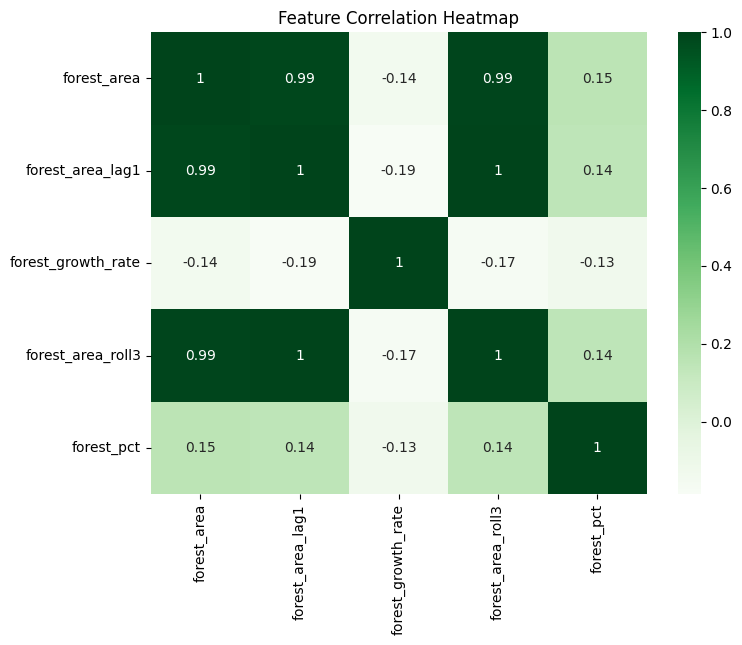

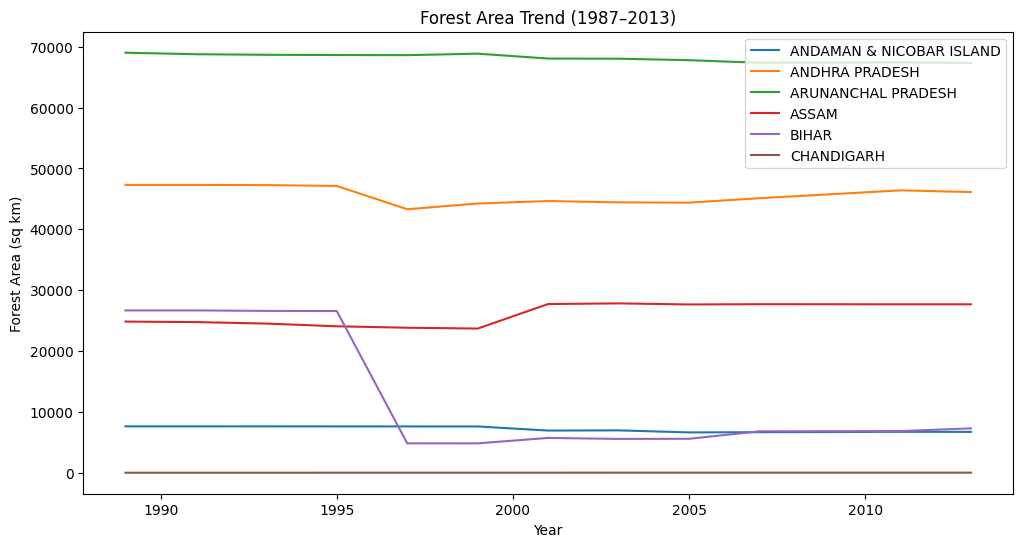

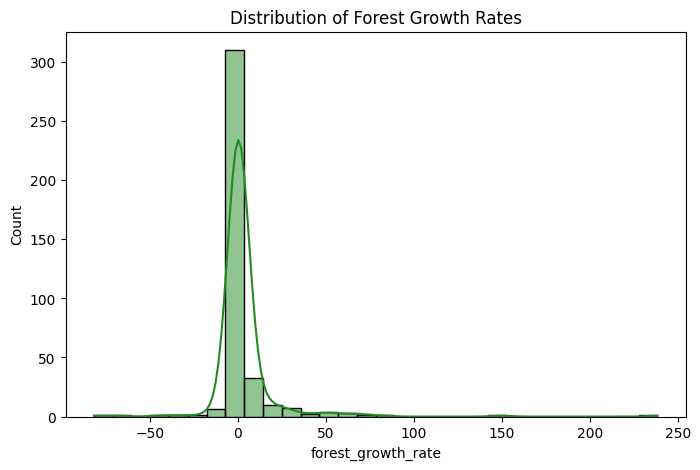

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm # Import statsmodels first
import seaborn as sns


# 1. Check correlation
corr = merged[['forest_area', 'forest_area_lag1', 'forest_growth_rate', 'forest_area_roll3', 'forest_pct']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='Greens')
plt.title("Feature Correlation Heatmap")
plt.show()

# 2. Visualize forest area trends for some major states
top_states = merged['state'].value_counts().head(6).index
plt.figure(figsize=(12,6))
for s in top_states:
    subset = merged[merged['state']==s]
    plt.plot(subset['year'], subset['forest_area'], label=s)
plt.legend()
plt.title("Forest Area Trend (1987–2013)")
plt.xlabel("Year")
plt.ylabel("Forest Area (sq km)")
plt.show()

# 3. Growth rate distribution
plt.figure(figsize=(8,5))
sns.histplot(merged['forest_growth_rate'], bins=30, kde=True, color='forestgreen')
plt.title("Distribution of Forest Growth Rates")
plt.show()

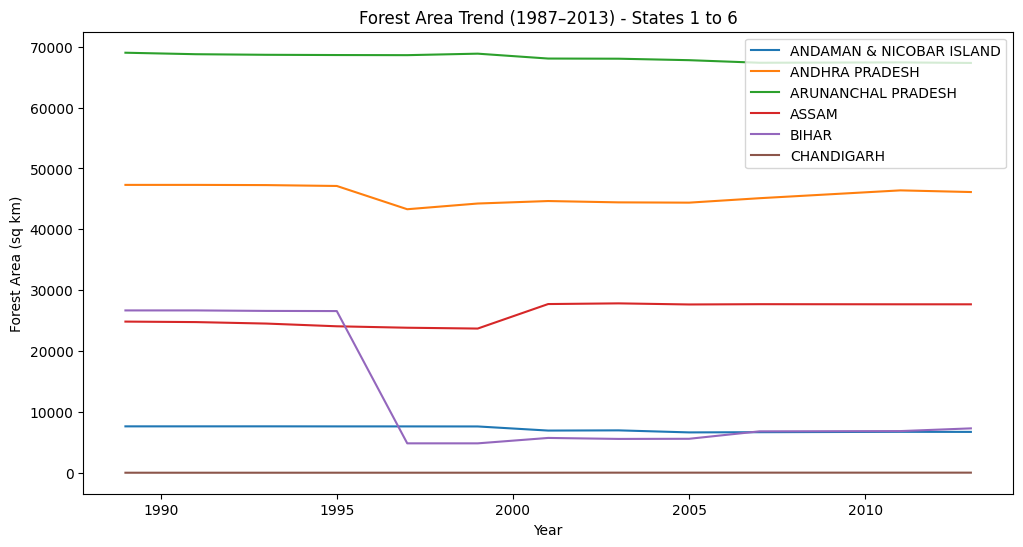

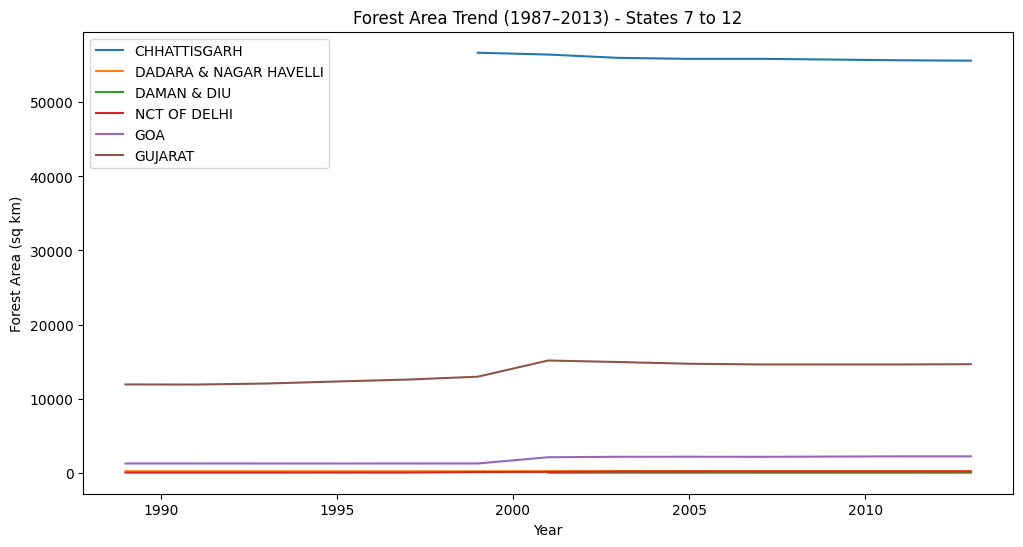

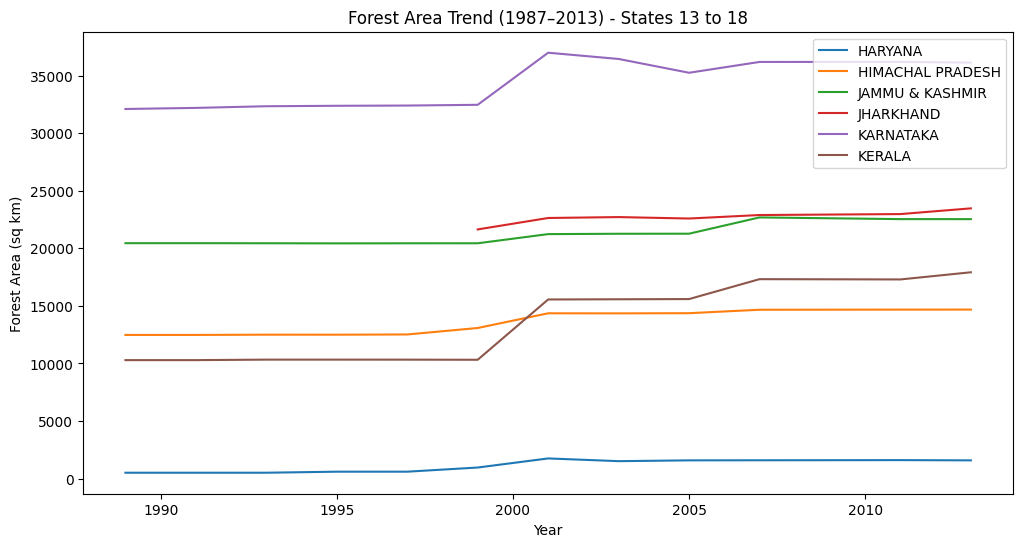

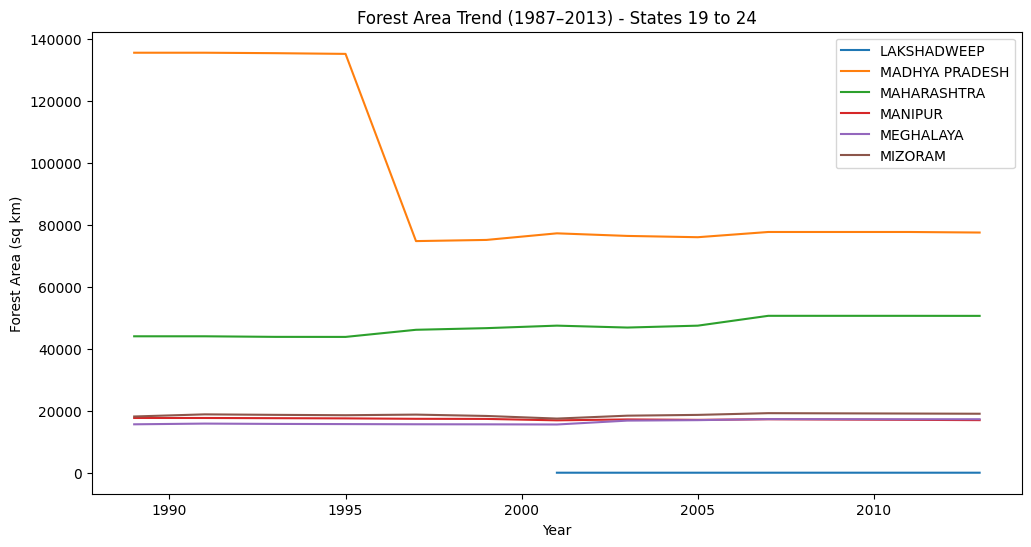

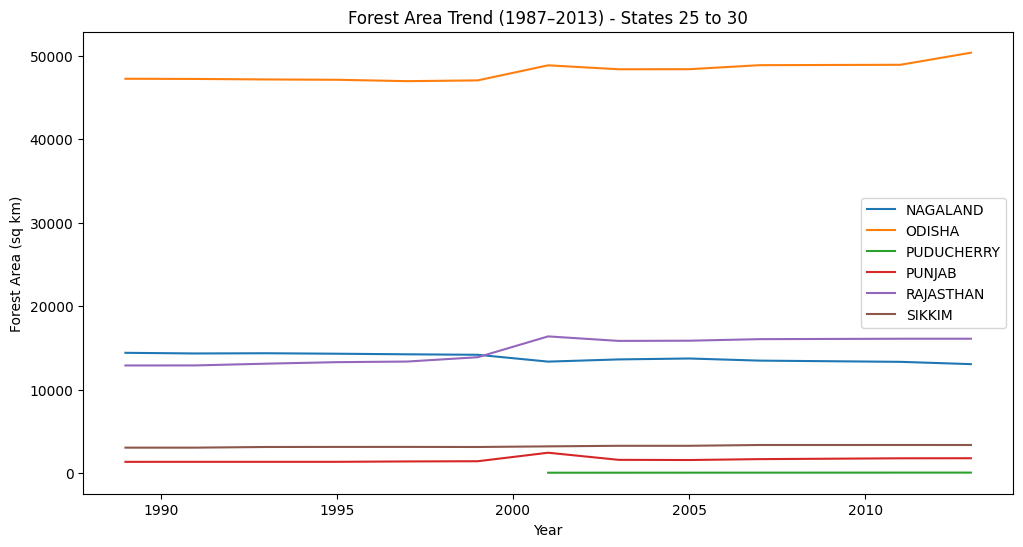

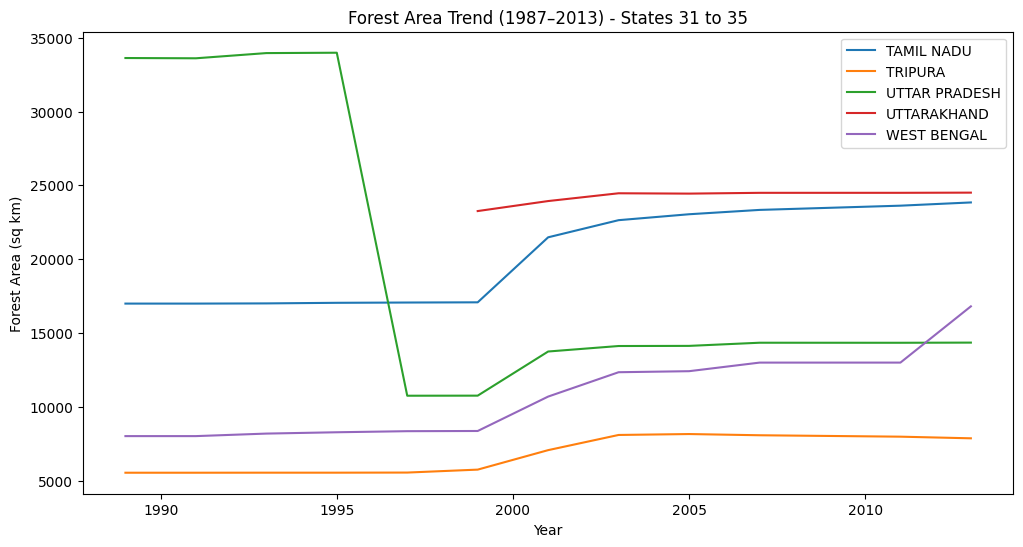

In [ ]:
# Visualize forest area trends in groups of 6 states

all_states = merged['state'].unique()
n_states = len(all_states)
states_per_plot = 6

for i in range(0, n_states, states_per_plot):
    states_chunk = all_states[i:i + states_per_plot]
    plt.figure(figsize=(12, 6))
    for s in states_chunk:
        subset = merged[merged['state'] == s]
        plt.plot(subset['year'], subset['forest_area'], label=s)
    plt.legend()
    plt.title(f"Forest Area Trend (1987–2013) - States {i+1} to {min(i+states_per_plot, n_states)}")
    plt.xlabel("Year")
    plt.ylabel("Forest Area (sq km)")
    plt.show()

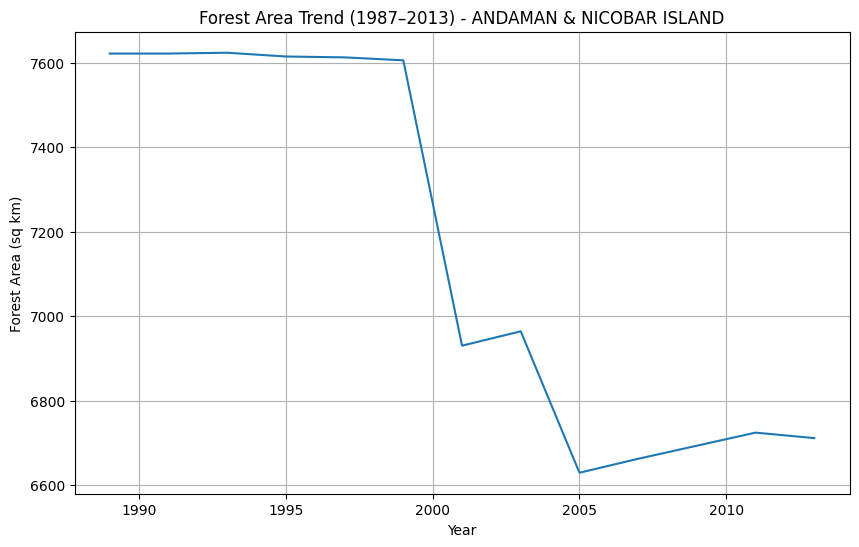

In [ ]:
# Plot forest area trend for a specific state

state_to_plot = 'ANDAMAN & NICOBAR ISLAND' #@param {type:"string"}

if state_to_plot in merged['state'].unique():
    subset = merged[merged['state'] == state_to_plot]
    plt.figure(figsize=(10, 6))
    plt.plot(subset['year'], subset['forest_area'])
    plt.title(f"Forest Area Trend (1987–2013) - {state_to_plot}")
    plt.xlabel("Year")
    plt.ylabel("Forest Area (sq km)")
    plt.grid(True)
    plt.show()
else:
    print(f"State '{state_to_plot}' not found in the data. Please check the state name.")
    print("Available states:", merged['state'].unique().tolist())

In [ ]:
# Create a dictionary of state-wise time series
state_ts = {state: df.set_index('year')['forest_area'].sort_index()
            for state, df in merged.groupby('state')}

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

forecast_results = {}

for state, series in state_ts.items():
    try:
        model = ARIMA(series, order=(1,1,1))
        model_fit = model.fit()
        # Predict 10 future years (increased from 5)
        future = model_fit.forecast(steps=10)
        forecast_results[state] = future
    except Exception as e:
        print(f"Could not forecast for {state}: {e}")
        continue

# Convert forecasts to DataFrame
forecast_df = pd.DataFrame(forecast_results)
# Don't explicitly set index, let it inherit from forecast results
# forecast_df.index = range(2015, 2020)  # REMOVE THIS LINE
forecast_df = forecast_df.reset_index().rename(columns={'index': 'year'})

forecast_df.head()

,year,ANDAMAN & NICOBAR ISLAND,ANDHRA PRADESH,ARUNANCHAL PRADESH,ASSAM,BIHAR,CHANDIGARH,CHHATTISGARH,DADARA & NAGAR HAVELLI,DAMAN & DIU,...,ODISHA,PUDUCHERRY,PUNJAB,RAJASTHAN,SIKKIM,TAMIL NADU,TRIPURA,UTTAR PRADESH,UTTARAKHAND,WEST BENGAL
0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.685484,...,NaN,52.481305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,NaN,NaN,NaN,NaN,NaN,NaN,55640.497030,NaN,12.076502,...,NaN,54.900363,NaN,NaN,NaN,NaN,NaN,NaN,24558.576735,NaN
2,8,NaN,NaN,NaN,NaN,NaN,NaN,55652.736387,NaN,12.139799,...,NaN,57.317176,NaN,NaN,NaN,NaN,NaN,NaN,24510.415691,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,55660.419702,NaN,12.150046,...,NaN,59.731747,NaN,NaN,NaN,NaN,NaN,NaN,24556.276425,NaN
4,10,NaN,NaN,NaN,NaN,NaN,NaN,55665.242941,NaN,12.151705,...,NaN,62.144077,NaN,NaN,NaN,NaN,NaN,NaN,24512.606132,NaN


In [ ]:
# Replace index with actual forecast years
# Updated forecast_years to reflect the increased steps (assuming last historical year is 2013 and forecasts are for consecutive periods)
last_historical_year = merged['year'].max()
forecast_years = range(last_historical_year + 2, last_historical_year + 2 + 10*2, 2) # Assuming biennial reports continue


# Create a new DataFrame with the correct index and aligned forecast values
forecast_df_reindexed = pd.DataFrame(index=forecast_years)

for state, forecast_series in forecast_results.items():
    # Ensure the forecast series has the same length as forecast_years (10 steps)
    # This assumes that each state's forecast_results contains 10 predicted steps
    if len(forecast_series) == len(forecast_years):
        forecast_df_reindexed[state] = forecast_series.values
    else:
        print(f"Warning: Forecast steps for {state} do not match expected {len(forecast_years)} steps.")
        # Attempt to align based on the number of steps, assuming the latest forecast points are desired
        forecast_df_reindexed[state] = forecast_series.tail(len(forecast_years)).values


forecast_df = forecast_df_reindexed

# Show first few rows again
display(forecast_df.head(10))

,ANDAMAN & NICOBAR ISLAND,ANDHRA PRADESH,ARUNANCHAL PRADESH,ASSAM,BIHAR,CHANDIGARH,CHHATTISGARH,DADARA & NAGAR HAVELLI,DAMAN & DIU,GOA,...,ODISHA,PUDUCHERRY,PUNJAB,RAJASTHAN,SIKKIM,TAMIL NADU,TRIPURA,UTTAR PRADESH,UTTARAKHAND,WEST BENGAL
2015,6709.348801,45955.245319,67259.121610,27886.590971,7291.000017,17.822125,55640.497030,212.240495,11.685484,2219.315302,...,50343.291236,52.481305,1721.234141,16339.593976,3382.122780,24418.847810,7823.523403,14348.999403,24558.576735,17544.441135
2017,6710.293532,46092.314830,67202.666366,28102.154194,7291.000000,18.319915,55652.736387,211.696172,12.076502,2219.358662,...,50341.828000,54.900363,1722.508027,16593.138193,3406.245055,24993.440861,7817.543326,14348.998806,24510.415691,18283.857046
2019,6709.753006,45975.440779,67151.158972,28317.689672,7291.000017,18.760734,55660.419702,211.306065,12.139799,2219.364625,...,50341.250703,57.317176,1722.476061,16846.632662,3430.366823,25567.779265,7816.701419,14348.998208,24556.276425,19023.247734
2021,6710.062267,46075.094917,67104.165789,28533.197408,7291.000000,19.151101,55665.242941,211.026483,12.150046,2219.365445,...,50341.022939,59.731747,1722.476863,17100.077392,3454.488086,26141.863136,7816.582891,14348.997611,24512.606132,19762.613200
2023,6709.885323,45990.123556,67061.291183,28748.677406,7291.000017,19.496791,55668.270753,210.826111,12.151705,2219.365557,...,50340.933078,62.144077,1722.476843,17353.472392,3478.608842,26715.692585,7816.566204,14348.997014,24554.190606,20501.953446
2025,6709.986561,46062.575461,67022.174192,28964.129669,7291.000000,19.802916,55670.171477,210.682508,12.151973,2219.365573,...,50340.897625,64.554169,1722.476843,17606.817674,3502.729093,27289.267727,7816.563855,14348.996417,24514.592326,21241.268471
2027,6709.928638,46000.798428,66986.485493,29179.554202,7291.000017,20.074006,55671.364666,210.579591,12.152017,2219.365575,...,50340.883637,66.962025,1722.476843,17860.113245,3526.848837,27862.588673,7816.563524,14348.995819,24552.299278,21980.558277
2029,6709.961779,46053.473396,66953.924622,29394.951008,7291.000000,20.314070,55672.113696,210.505832,12.152024,2219.365575,...,50340.878118,69.367647,1722.476843,18113.359117,3550.968076,28435.655536,7816.563478,14348.995222,24516.393319,22719.822864
2031,6709.942817,46008.559419,66924.217451,29610.320089,7291.000017,20.526659,55672.583903,210.452970,12.152025,2219.365575,...,50340.875941,71.771036,1722.476843,18366.555299,3575.086808,29008.468429,7816.563471,14348.994625,24550.584305,23459.062234
2033,6709.953666,46046.855890,66897.113876,29825.661451,7291.000000,20.714917,55672.879078,210.415085,12.152025,2219.365575,...,50340.875082,74.172195,1722.476843,18619.701800,3599.205035,29581.027465,7816.563470,14348.994028,24518.026379,24198.276387


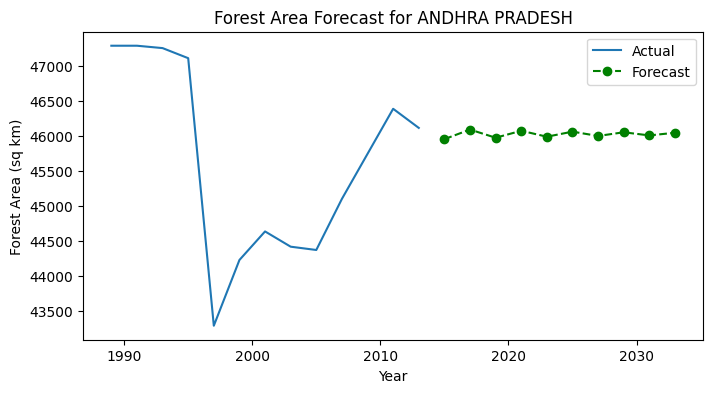

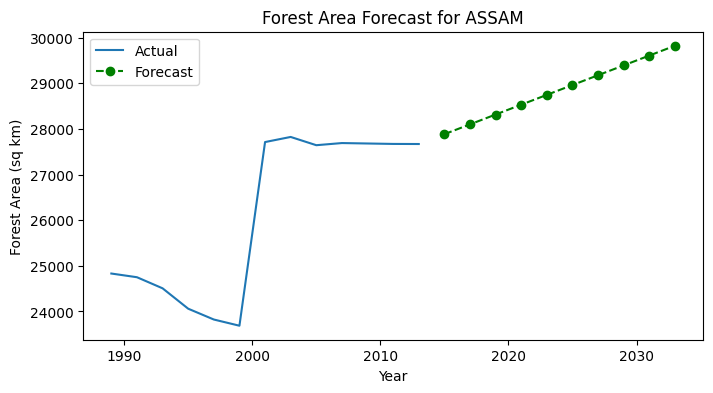

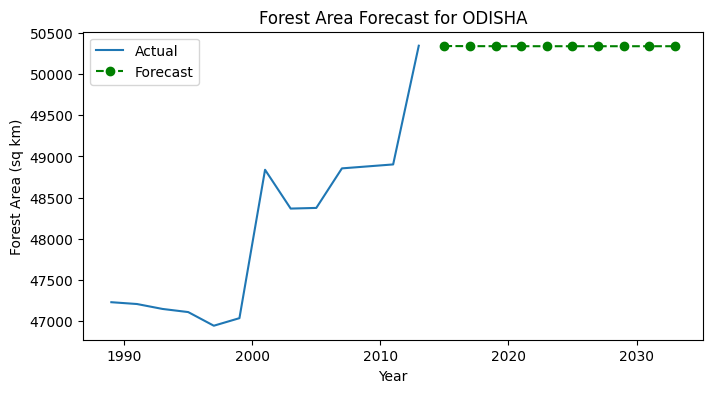

In [ ]:
import matplotlib.pyplot as plt

states_to_plot = ['ANDHRA PRADESH', 'ASSAM', 'ODISHA']
for s in states_to_plot:
    actual = merged[merged['state'] == s]
    plt.figure(figsize=(8,4))
    plt.plot(actual['year'], actual['forest_area'], label='Actual')
    plt.plot(forecast_df.index, forecast_df[s], '--o', label='Forecast', color='green')
    plt.title(f"Forest Area Forecast for {s}")
    plt.xlabel("Year")
    plt.ylabel("Forest Area (sq km)")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np # Import numpy

# Prepare data
ml_data = merged.dropna(subset=['forest_area_lag1', 'forest_area_roll3', 'forest_growth_rate'])

# Replace infinite values with NaN and drop rows
ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_data.dropna(inplace=True)

X = ml_data[['forest_area_lag1', 'forest_area_roll3', 'forest_growth_rate', 'forest_pct']]
y = ml_data['forest_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.9984539719321675
MAE: 422.74584415584405


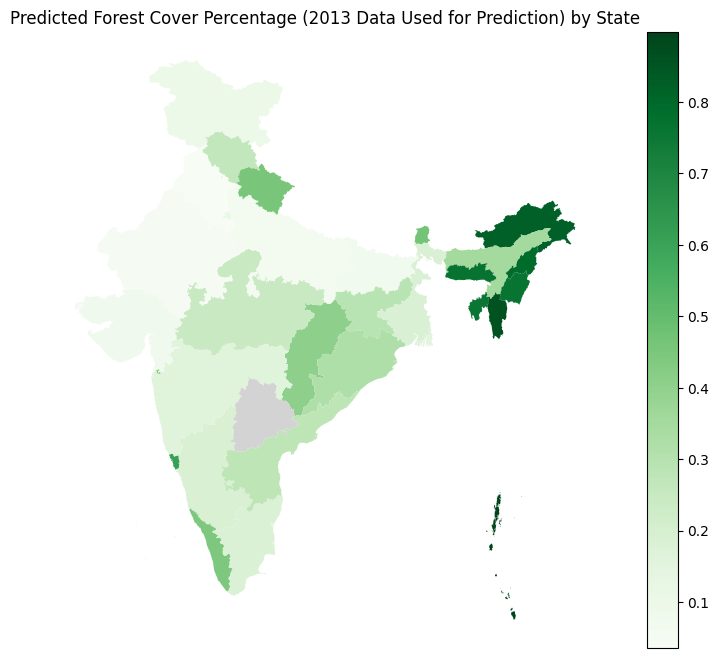

In [ ]:
# Make predictions using the trained Random Forest model for the latest year available

# Use the latest year's data as input for prediction
latest_year_data = merged[merged['year'] == merged['year'].max()].copy()

# Select features for prediction. Ensure these match the training features.
X_latest = latest_year_data[['forest_area_lag1', 'forest_area_roll3', 'forest_growth_rate', 'forest_pct']]

# Handle potential NaN or inf values in the latest data before prediction
X_latest.replace([np.inf, -np.inf], np.nan, inplace=True)
# For simplicity, we will drop rows with NaN values in the latest year's features.
# A more sophisticated approach might involve imputation.
latest_year_data_cleaned = latest_year_data.dropna(subset=X_latest.columns)
X_latest_cleaned = latest_year_data_cleaned[['forest_area_lag1', 'forest_area_roll3', 'forest_growth_rate', 'forest_pct']]


# Make predictions
# Ensure the trained model 'rf' is available from the previous cell
predicted_forest_area = rf.predict(X_latest_cleaned)

# Add predictions to the cleaned latest year data
latest_year_data_cleaned['predicted_forest_area'] = predicted_forest_area

# Merge predictions with GIS data
# Assuming india_gdf is available from previous cells and contains 'st_nm', 'geometry', and 'area_ha'
predicted_map_df = india_gdf.merge(latest_year_data_cleaned[['state', 'predicted_forest_area']],
                                   left_on='st_nm', right_on='state', how='left')

# Calculate predicted forest cover percentage
predicted_map_df['predicted_forest_pct'] = (predicted_map_df['predicted_forest_area'] / predicted_map_df['area_ha']) * 100

# Visualize the predicted forest cover percentage
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
predicted_map_df.plot(column='predicted_forest_pct', cmap='Greens', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
ax.set_title(f"Predicted Forest Cover Percentage ({merged['year'].max()} Data Used for Prediction) by State")
ax.set_axis_off()
plt.show()

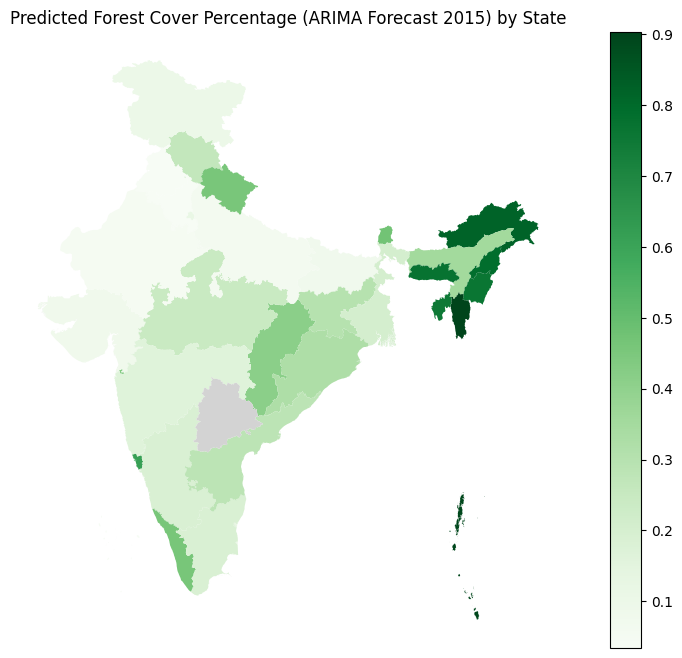

In [ ]:
# Visualize ARIMA predicted forest cover % for a specific forecast year

# Assuming forecast_df from ARIMA forecasting is available
# Assuming india_gdf with 'st_nm' and 'area_ha' is available

forecast_year_to_plot = 2015 #@param {type:"raw"}

if forecast_year_to_plot in forecast_df.index:
    # Get predictions for the selected forecast year
    predicted_year_data = forecast_df.loc[[forecast_year_to_plot]].transpose().reset_index()
    predicted_year_data.columns = ['state', 'predicted_forest_area']

    # Merge predictions with GIS data
    predicted_arima_map_df = india_gdf.merge(predicted_year_data,
                                            left_on='st_nm', right_on='state', how='left')

    # Calculate predicted forest cover percentage
    predicted_arima_map_df['predicted_forest_pct'] = (predicted_arima_map_df['predicted_forest_area'] / predicted_arima_map_df['area_ha']) * 100

    # Visualize the predicted forest cover percentage
    import geopandas as gpd
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    predicted_arima_map_df.plot(column='predicted_forest_pct', cmap='Greens', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
    ax.set_title(f"Predicted Forest Cover Percentage (ARIMA Forecast {forecast_year_to_plot}) by State")
    ax.set_axis_off()
    plt.show()
else:
    print(f"Forecast year {forecast_year_to_plot} not found in ARIMA forecasts.")
    print("Available forecast years:", forecast_df.index.tolist())

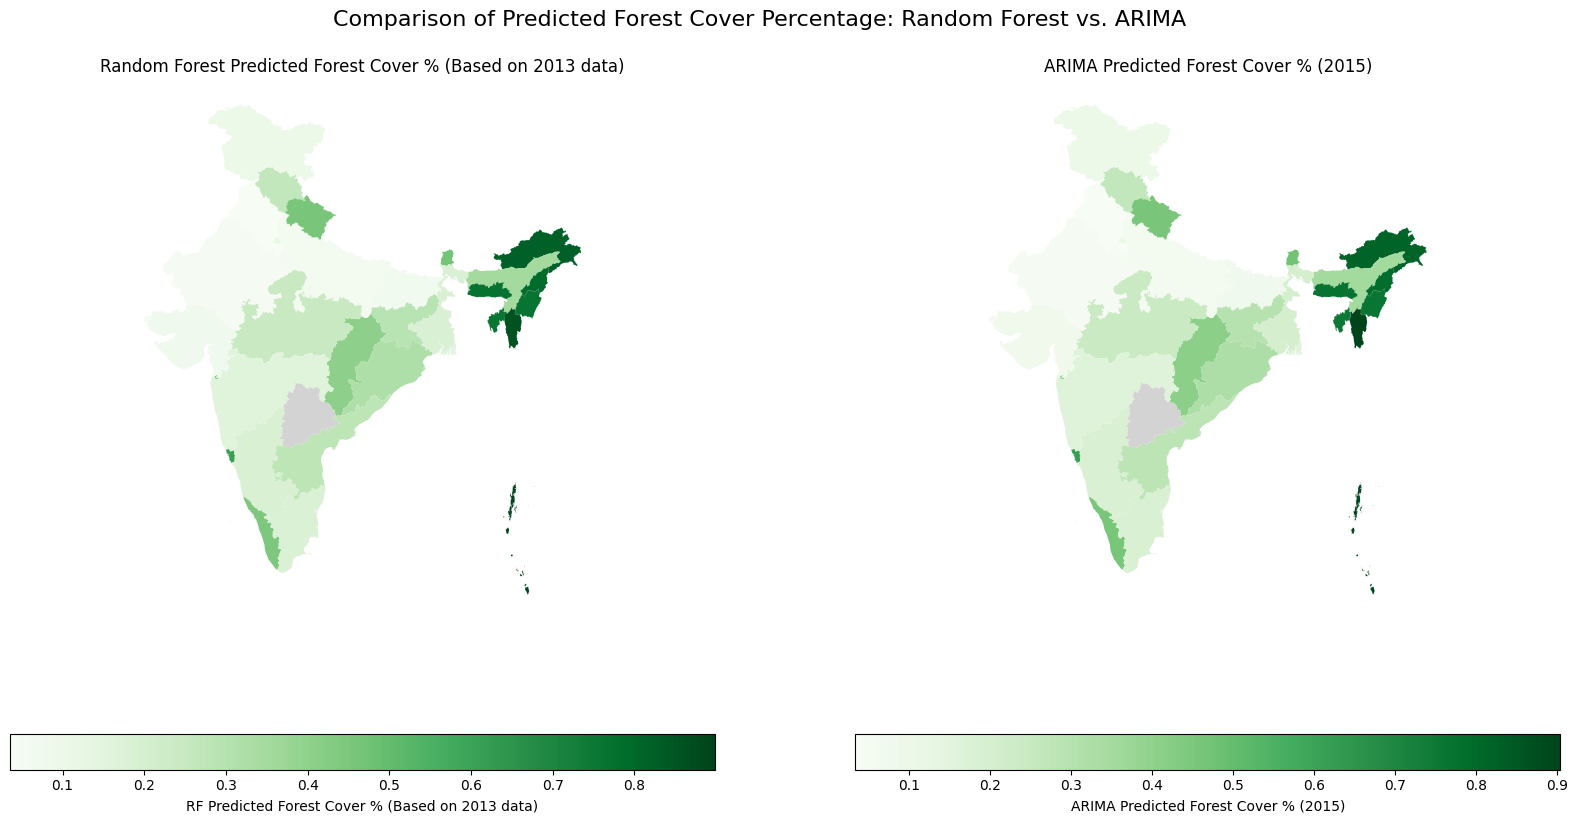

In [ ]:
# Compare predicted forest cover percentage from Random Forest and ARIMA

# Assuming predicted_map_df (from Random Forest predictions based on 2013 data) is available
# Assuming predicted_arima_map_df (from ARIMA forecast for a selected year) is available

# Select the forecast year for ARIMA comparison (defaulting to 2023 as visualized previously)
arima_comparison_year = 2015 #@param {type:"raw"}

if arima_comparison_year in forecast_df.index:

    # Get ARIMA predictions for the selected year
    predicted_arima_year_data = forecast_df.loc[[arima_comparison_year]].transpose().reset_index()
    predicted_arima_year_data.columns = ['state', 'predicted_forest_area_arima']

    # Merge ARIMA predictions with GIS data to calculate percentage
    predicted_arima_map_df_comp = india_gdf.merge(predicted_arima_year_data,
                                                  left_on='st_nm', right_on='state', how='left')
    predicted_arima_map_df_comp['predicted_forest_pct_arima'] = (predicted_arima_map_df_comp['predicted_forest_area_arima'] / predicted_arima_map_df_comp['area_ha']) * 100

    # Merge Random Forest predictions with the ARIMA comparison data
    comparison_map_df = predicted_map_df.merge(predicted_arima_map_df_comp[['st_nm', 'predicted_forest_pct_arima']],
                                               on='st_nm', how='left')


    # Visualize side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Plot Random Forest predictions (based on 2013 data)
    comparison_map_df.plot(column='predicted_forest_pct', cmap='Greens', legend=True,
                           ax=axes[0], missing_kwds={'color': 'lightgrey'},
                           legend_kwds={'label': "RF Predicted Forest Cover % (Based on 2013 data)", 'orientation': "horizontal"})
    axes[0].set_title(f"Random Forest Predicted Forest Cover % (Based on 2013 data)")
    axes[0].set_axis_off()

    # Plot ARIMA predictions for the selected year
    comparison_map_df.plot(column='predicted_forest_pct_arima', cmap='Greens', legend=True,
                           ax=axes[1], missing_kwds={'color': 'lightgrey'},
                           legend_kwds={'label': f"ARIMA Predicted Forest Cover % ({arima_comparison_year})", 'orientation': "horizontal"})
    axes[1].set_title(f"ARIMA Predicted Forest Cover % ({arima_comparison_year})")
    axes[1].set_axis_off()

    plt.suptitle("Comparison of Predicted Forest Cover Percentage: Random Forest vs. ARIMA", y=0.95, fontsize=16)
    plt.show()

else:
    print(f"ARIMA forecast year {arima_comparison_year} not found in forecasts.")
    print("Available ARIMA forecast years:", forecast_df.index.tolist())

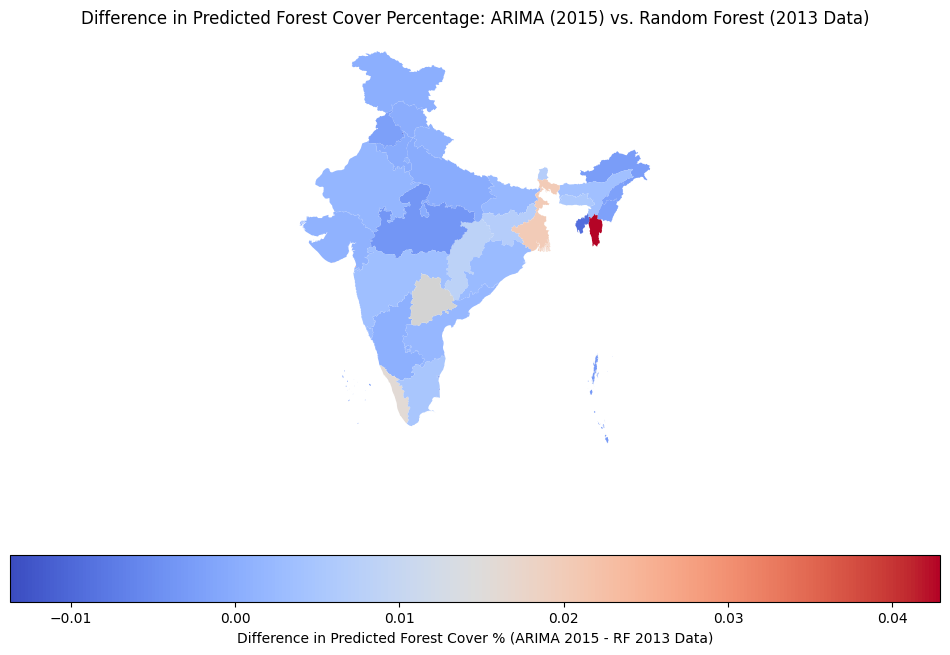

,st_nm,predicted_forest_pct,predicted_forest_pct_arima,predicted_forest_pct_difference
4,CHANDIGARH,0.164333,0.150635,-0.013698
30,TRIPURA,0.758558,0.749340,-0.009218
24,PUDUCHERRY,0.111107,0.104761,-0.006346
17,MADHYA PRADESH,0.251236,0.247627,-0.003609
0,ANDAMAN & NICOBAR ISLAND,0.897980,0.894781,-0.003199
16,LAKSHADWEEP,0.042221,0.039662,-0.002558
1,ARUNANCHAL PRADESH,0.821512,0.819082,-0.002431
25,PUNJAB,0.036248,0.034133,-0.002114
19,MANIPUR,0.763352,0.761392,-0.001960
22,NAGALAND,0.791240,0.789368,-0.001872


In [ ]:
# Calculate and visualize the difference in predicted forest cover percentage between ARIMA and Random Forest

# Assuming comparison_map_df (containing predictions from both models and GIS data) is available
# arima_comparison_year is also available

# Calculate the difference in predicted forest cover percentage
# Difference = ARIMA Prediction - Random Forest Prediction
comparison_map_df['predicted_forest_pct_difference'] = comparison_map_df['predicted_forest_pct_arima'] - comparison_map_df['predicted_forest_pct']

# Visualize the difference
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
comparison_map_df.plot(column='predicted_forest_pct_difference', cmap='coolwarm', legend=True,
                       ax=ax, missing_kwds={'color': 'lightgrey'},
                       legend_kwds={'label': f"Difference in Predicted Forest Cover % (ARIMA {arima_comparison_year} - RF 2013 Data)", 'orientation': "horizontal"})
ax.set_title(f"Difference in Predicted Forest Cover Percentage: ARIMA ({arima_comparison_year}) vs. Random Forest (2013 Data)")
ax.set_axis_off()
plt.show()

# Display a summary of the differences
display(comparison_map_df[['st_nm', 'predicted_forest_pct', 'predicted_forest_pct_arima', 'predicted_forest_pct_difference']].sort_values('predicted_forest_pct_difference'))

## Define and fit lmm




In [ ]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

# Define the model formula: forest_area is the dependent variable, year is the fixed effect
# Random intercepts are included by default when specifying groups
model_formula = 'forest_area ~ year'

# Fit the Linear Mixed Effects Model
# Use smf.mixedlm to leverage formula API
lmm_model = smf.mixedlm(model_formula, data=merged, groups=merged['state']).fit()

# Display the model summary
print(lmm_model.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   forest_area  
No. Observations:    387       Method:               REML         
No. Groups:          35        Scale:                34340139.5907
Min. group size:     6         Log-Likelihood:       -3979.6240   
Max. group size:     12        Converged:            Yes          
Mean group size:     11.1                                         
------------------------------------------------------------------
              Coef.      Std.Err.   z    P>|z|  [0.025    0.975]  
------------------------------------------------------------------
Intercept    167527.888 83200.952  2.014 0.044 4457.018 330598.758
year            -73.769    41.532 -1.776 0.076 -155.170      7.632
Group Var 474030203.548 20687.094                                 



## Interpret lmm results




In [ ]:
# 1. Examine the printed summary of the lmm_model (already done in the previous cell, repeating here for clarity)
print("--- LMM Model Summary ---")
print(lmm_model.summary())

# 2. Interpret the fixed effect for 'year'
print("\n--- Fixed Effects Interpretation ---")
print(f"Coefficient for 'year': {lmm_model.fe_params['year']:.4f}")
print(f"P-value for 'year': {lmm_model.pvalues['year']:.4f}")

# 3. Examine the random effect variance for 'state'
# Corrected attribute access
print("\n--- Random Effects Interpretation ---")
# Access the variance component using the group name as the key
print(f"Variance component for 'state' group: {lmm_model.cov_re.iloc[0, 0]:.4f}")


# 4. Note model fit statistics (print some key ones)
print("\n--- Model Fit Statistics ---")
print(f"Log-Likelihood: {lmm_model.llf:.4f}")
print(f"AIC: {lmm_model.aic:.4f}")
print(f"BIC: {lmm_model.bic:.4f}")

# 5. Summarize interpretation
print("\n--- Summary Interpretation ---")
print(f"The fixed effect for 'year' ({lmm_model.fe_params['year']:.4f}) indicates the estimated average annual change in forest area across all states.")
print(f"The p-value for 'year' ({lmm_model.pvalues['year']:.4f}) suggests the statistical significance of this average change (note that p-value is slightly above 0.05, indicating marginal significance at a 5% level).")
print(f"The significant variance component for the 'state' group ({lmm_model.cov_re.iloc[0, 0]:.4f}) indicates that there are considerable state-specific deviations from this average annual trend, meaning different states have different baseline forest areas or trends.")

--- LMM Model Summary ---
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   forest_area  
No. Observations:    387       Method:               REML         
No. Groups:          35        Scale:                34340139.5907
Min. group size:     6         Log-Likelihood:       -3979.6240   
Max. group size:     12        Converged:            Yes          
Mean group size:     11.1                                         
------------------------------------------------------------------
              Coef.      Std.Err.   z    P>|z|  [0.025    0.975]  
------------------------------------------------------------------
Intercept    167527.888 83200.952  2.014 0.044 4457.018 330598.758
year            -73.769    41.532 -1.776 0.076 -155.170      7.632
Group Var 474030203.548 20687.094                                 


--- Fixed Effects Interpretation ---
Coefficient for 'year': -73.7690
P-value for 'year': 0.0757

--- Random Effects